In [1]:
import numpy as np
import pandas as pd
import itertools as it

import seaborn as sns
import glob
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import json
import sys
import os
import pymc3
import pystan
import matplotlib
from scipy.stats import rankdata

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42



import numpy as np
from collections import OrderedDict

def ilogit(x):
    return 1/(1+np.exp(-x))

#From https://gist.github.com/lwiklendt/9c7099288f85b59edc903a5aed2d2d64
def pystan_vb_extract(results):
    param_specs = results['sampler_param_names']
    samples = results['sampler_params']
    n = len(samples[0])

    # first pass, calculate the shape
    param_shapes = OrderedDict()
    for param_spec in param_specs:
        splt = param_spec.split('[')
        name = splt[0]
        if len(splt) > 1:
            idxs = [int(i) for i in splt[1][:-1].split(',')]  # no +1 for shape calculation because pystan already returns 1-based indexes for vb!
        else:
            idxs = ()
        param_shapes[name] = np.maximum(idxs, param_shapes.get(name, idxs))

    # create arrays
    params = OrderedDict([(name, np.nan * np.empty((n, ) + tuple(shape))) for name, shape in param_shapes.items()])

    # second pass, set arrays
    for param_spec, param_samples in zip(param_specs, samples):
        splt = param_spec.split('[')
        name = splt[0]
        if len(splt) > 1:
            idxs = [int(i) - 1 for i in splt[1][:-1].split(',')]  # -1 because pystan returns 1-based indexes for vb!
        else:
            idxs = ()
        params[name][(..., ) + tuple(idxs)] = param_samples

    return params


<h1>Data Import and Restructuring</h1>


In [2]:
##Load Datasets In
raw_exp1 = pd.read_csv('../Data/Experiment1.csv')
raw_exp1 = raw_exp1.iloc[np.where(~pd.isnull(raw_exp1['Q19Social']))] #Exclude incomplete responses
raw_exp1.head()
data = raw_exp1.copy()

In [3]:
#Reshape the data such that each question is a row. 
def custom_melt(row, n_questions=20):
    response = [] #The answer they gave
    numConf = [] #Their raw reported confidence. 
    qualConf = [] #Their qualitatively reported confidence. 
    socialAnswer = [] #The social information they received. 
    socialNumConf = [] #Their confidence after receiving social information. 
    socialQualConf = [] #The qualitative ocnfidence after receiving social information. 
    answers = [] #The correct answer. 
    states=[] #The state .
    trueSocial = [] #The correct answer.  
    socialSize = [] #The number of individuals they interacted with. 
    
    #Loop through each question they recieved (20 question total) and determine what question they had an what answer they gave. 
    
    for idx in range(n_questions):
        response.append(row['Q'+str(idx)])
        numConf.append(row['Q'+str(idx)+'S_1'])
        qualConf.append(row['Q'+str(idx)+'T'])
        socialAnswer.append(row['Q'+str(idx)+'Social'])
        socialNumConf.append(row['Q'+str(idx)+'SocialS_1'])
        socialQualConf.append(row['Q'+str(idx)+'SocialT'])
        answers.append(row['answer'+str(idx)])
        states.append(row['abbr'+str(idx)])
        trueSocial.append(row['trueVal'+str(idx)])
        socialSize.append(row['resp'+str(idx)])
        
    #STore their data as a dict. 
    dataDict = {'response':response,
               'numConf':numConf,
               'qualConf':qualConf,
               'socialAnswer':socialAnswer,
               'socialNumConf':socialNumConf,
               'socialQualConf':socialQualConf,
               'answer':answers,
               'states':states,
               'id':row['CintID'],
               'gender':row['gender'],
               'politics':row['politics'],
               'education':row['education'],
               'age':row['age'],
               'socialSize':socialSize,
               'socialInfo':trueSocial} ##probability social information indicates correct answer
    #Make a list of dictionaries. 
    return pd.DataFrame(dataDict)
raw_exp1.apply(custom_melt, axis=1)
data_exp1 = pd.concat([item for item in data.apply(custom_melt, axis=1)] )


In [4]:
#Determine if the participants were correct, drop empty frames. 

data_exp1['correct_start'] = data_exp1.answer == data_exp1.response
data_exp1 = data_exp1.dropna()

#Split data into those where the correct answer is true and compute the proportion correct (difficulty)
true_data = data_exp1[data_exp1.answer==True]
difficulty = dict(zip(true_data.groupby('states').mean().correct_start.keys(), 
                      true_data.groupby('states').mean().correct_start.values))
true_data['difficulty'] = [difficulty[item] for item in true_data.states.values]

#Split data into those where the correct answer is false and compute the proportion correct (difficulty)
false_data = data_exp1[data_exp1.answer==False]
difficulty = dict(zip(false_data.groupby('states').mean().correct_start.keys(), 
                      false_data.groupby('states').mean().correct_start.values))
false_data['difficulty'] = [difficulty[item] for item in false_data.states.values]

#Merge those two
data = pd.concat([true_data,false_data])

#Use a dictionary to recode political leaning, gender, education, id and age
pol_dict = {'Very Conservative':1, 'Conservative':2,'Moderate':3, 'Liberal':4,'Very Liberal':5}
data['pol_recode'] = [pol_dict[item] for item in data.politics]


gender_dict = {'Male':1, 'Female':2,'Other/Prefer not to say':3}
data['gender_recode'] = [gender_dict[item] for item in data.gender]

edu_dict = {'Graduate Degree or Higher':1 ,'College':2 ,'Some College':3 ,'High School':4,'Some High School':5}
data['edu_recode'] = [edu_dict[item] for item in data.education]

age_dict = {'18-24':1,'25-34':2,'35-44':3,'45-54':4,'55-64':5,'65+':6}
data['age_recode'] = [age_dict[item] for item in data.age]

id_recode = [dict(zip(np.unique(data.id), np.arange(np.unique(data.id).shape[0])))[ids] for ids in data.id.values]
data['id_recode'] = id_recode

state_recode = [dict(zip(np.unique(data.states), np.arange(np.unique(data.states).shape[0])))[state] for state in data.states.values]
data['state_recode'] = state_recode
#Save that to the preliminarily parsed data. 
false_data.head()

/Users/josephbak-coleman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/josephbak-coleman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,response,numConf,qualConf,socialAnswer,socialNumConf,socialQualConf,answer,states,id,gender,politics,education,age,socialSize,socialInfo,correct_start,difficulty
0,True,96.0,I am unsure if it is correct,True,90.0,It is certainly correct,False,UT,785607b7-fa3a-ed8c-abaf-317d3f2c3561,Male,Very Conservative,Graduate Degree or Higher,25-34,13.0,35.0,False,0.907895
3,True,100.0,I am unsure if it is correct,True,96.0,It is probably correct,False,WI,785607b7-fa3a-ed8c-abaf-317d3f2c3561,Male,Very Conservative,Graduate Degree or Higher,25-34,8.0,29.0,False,0.609375
4,True,96.0,It is probably correct,True,97.0,It is probably correct,False,PA,785607b7-fa3a-ed8c-abaf-317d3f2c3561,Male,Very Conservative,Graduate Degree or Higher,25-34,1.0,5.0,False,0.416667
6,True,100.0,I am unsure if it is correct,True,96.0,It is probably correct,False,CT,785607b7-fa3a-ed8c-abaf-317d3f2c3561,Male,Very Conservative,Graduate Degree or Higher,25-34,12.0,82.0,False,0.702381
8,True,100.0,It is certainly correct,True,98.0,It is probably correct,False,WV,785607b7-fa3a-ed8c-abaf-317d3f2c3561,Male,Very Conservative,Graduate Degree or Higher,25-34,11.0,84.0,False,0.698413


<h3>Demographic Figure</h3>


(545, 292)


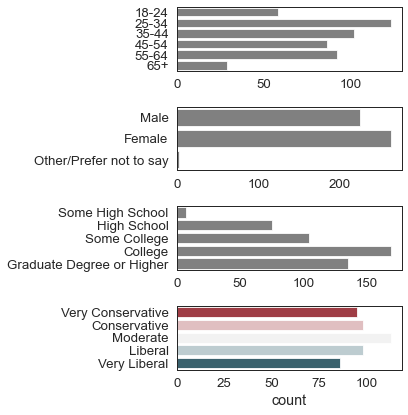

In [5]:
#Set some basic plotting parameters. 
sns.set_style('white')
sns.set_context('paper',font_scale=1.5)
#Load the unparsed data
unparsed = pd.read_csv('../Data/Experiment1.csv')
print(unparsed.shape)

#Plot age demographics
plt.figure(figsize=(6,6))
plt.subplot(4,1,1)
sns.countplot(y=unparsed.age,color='grey',order=['18-24','25-34','35-44','45-54','55-64','65+'])
plt.ylabel('')
plt.xlabel('')

#Plot gender demographics
plt.subplot(4,1,2)
sns.countplot(y=unparsed.gender,color='grey')
plt.ylabel('')
plt.xlabel('')
plt.subplot(4,1,3)

#Plot education demographics
sns.countplot(y=unparsed.education,color='grey',order=['Some High School','High School',
                                                      'Some College','College','Graduate Degree or Higher'])
plt.ylabel('')
plt.xlabel('')

#Plot political leaning demographics
plt.subplot(4,1,4)
sns.set_palette(sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light'))
sns.countplot(y=unparsed.politics,
              order=['Very Conservative','Conservative','Moderate','Liberal','Very Liberal'],)
plt.ylabel('')
plt.tight_layout()
plt.savefig('../Graphs/Demographics_Exp1.pdf',fmt='pdf',dpi=1500)

In [6]:
## Social Influence Model
false_data = data[data.answer==False]
true_data = data[data.answer==True]

false_data.to_csv('../Data/False_Data.csv')
true_data.to_csv('../Data/True_Data.csv')


In [7]:
##Save data for loading so you don't have to bring it in and restructure it each time.
false_data = pd.read_csv('../Data/False_Data.csv')
true_data = pd.read_csv('../Data/True_Data.csv')

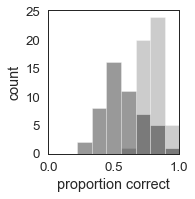

In [8]:
##Here we plot distributrions of how many individuals were correct for each states. 

def fig1a():
    #Basic figure paramters
    sns.set_context('paper', font_scale=1.5)
    plt.figure(figsize=(3,3))

    #Plot distributions, adjust legend etc... 
    sns.distplot(true_data.groupby(['states']).mean()['correct_start'],
                 color='grey',bins=np.linspace(0,1,10),label='True',kde=False)
    sns.distplot(false_data.groupby(['states']).mean()['correct_start'],
                 color='black',bins=np.linspace(0,1,10),label='False',kde=False)
    plt.yticks(np.linspace(0,25,6))
    plt.xlim(0,1)
    plt.xlabel('proportion correct')
    plt.ylabel('count')
    

    #Save figure
    plt.tight_layout() 
    
fig1a()

In [9]:
code = '''
data {
int n; 
real x[n];
int j; 
int who[n];
int pol[j];
int NStates;
int state[n];
int<lower=0, upper=1> correct[n];
}

parameters {
real alpha[j];
real beta[j];
real alpha_p[5];
real beta_p[5];

vector[NStates-1] beta_state_raw;
}

transformed parameters {
  vector[NStates] beta_state = append_row(beta_state_raw, -sum(beta_state_raw));
}


model {
real theta[n];

for (p in 1:5){
alpha_p[p] ~ normal(0,5);
beta_p[p] ~ normal(0,2.5);
}

beta_state ~ normal(0,5);



for(jj in 1:j){

alpha[jj] ~ normal(alpha_p[pol[jj]], 1);
beta[jj] ~ normal(beta_p[pol[jj]], 1);

}

for (i in 1:n) {
 
theta[i] = alpha[who[i]] + beta[who[i]]*x[i] + beta_state[state[i]];
}



correct ~ bernoulli_logit(theta);
}


'''
model_logistic = pystan.StanModel(model_code=code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_09c6760d02398bb1ebd541077f742a05 NOW.


In [10]:
smaller_data = false_data.copy()
pols = []
for idx in np.unique(smaller_data['id_recode']):
    pols.append(int(np.mean(smaller_data['pol_recode'][smaller_data['id_recode']==idx])))
stan_data_logistic = dict(correct = smaller_data['correct_start'].astype('int').values,
                    j = np.unique(smaller_data['id_recode']).shape[0],
                    n = smaller_data.shape[0],
                    P = 5, 
                    state = smaller_data['state_recode'].values+1,
                    NStates = np.unique(smaller_data['state_recode']).shape[0],
                    pol = np.array(pols),
                    x =  2*((smaller_data['numConf'].values-50)/50-.5),
                    who = smaller_data['id_recode']+1)





INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [11]:
samples_logistic = model_logistic.sampling(data = stan_data_logistic)


In [12]:
samples_logistic


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_09c6760d02398bb1ebd541077f742a05.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%     25%     50%     75%  97.5%  n_eff   Rhat
alpha[1]   -0.02  7.2e-3   0.55  -1.08   -0.38   -0.01    0.34    1.1   5881    1.0
alpha[2]    0.42  8.9e-3   0.72  -0.97   -0.05    0.44     0.9   1.85   6401    1.0
alpha[3]    -0.1  7.7e-3   0.61  -1.28   -0.52   -0.11    0.31   1.09   6408    1.0
alpha[4]   -0.02    0.01   0.75   -1.5   -0.53 -6.9e-3    0.46   1.45   4347    1.0
alpha[5]    0.56  9.3e-3    0.7  -0.76    0.06    0.55    1.05   1.97   5702    1.0
alpha[6]   -0.87    0.02   0.84  -2.53   -1.44   -0.88   -0.32   0.75   2513    1.0
alpha[7]   -0.26    0.01   0.74  -1.72   -0.75   -0.27    0.24   1.17   4509    1.0
alpha[8]    -0.4  9.7e-3   0.63  -1.65   -0.82   -0.38    0.03   0.83   4278    1.0
alpha[9]    0.2

In [13]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
with open('../ModelPickles/model_logistic.p', 'wb') as output:
    pickle.dump(model_logistic, output, pickle.HIGHEST_PROTOCOL)
with open('../ModelPickles/model_logistic_samples.p', 'wb') as output:
    pickle.dump(samples_logistic, output, pickle.HIGHEST_PROTOCOL)

FileNotFoundError: [Errno 2] No such file or directory: '../ModelPickles/model_logistic.p'

In [ ]:
def pickle_model(model, ctry:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
with open('../ModelPickles/model_logistic.p', 'rb') as input:
    model_logistic = pickle.load(input)
with open('../ModelPickles/model_logistic_samples.p', 'rb') as input:
    samples_logistic = pickle.load(input)

In [ ]:

print(samples_logistic.stansummary(pars=['alpha_p', 'beta_p'],probs=[.055, .5, .945]))
samples_extracted = samples_logistic.extract(pars=['alpha_p', 'beta_p'])


In [ ]:
samples_logistic.plot(pars=['alpha_p', 'beta_p'])


In [ ]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
def plot_figure1b():
    pal = sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light')
    pal2 = sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='dark')
    pal[2] = pal2[2]
    for idx in range(5):
        x = samples_extracted['alpha_p'][:,idx]
        y = samples_extracted['beta_p'][:,idx]
        k = gaussian_kde(np.vstack([x, y]))
        xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))

        #set zi to 0-1 scale
        zi = (zi-zi.min())/(zi.max() - zi.min())
        zi =zi.reshape(xi.shape)

        #set up plot
        origin = 'lower'
        levels = [.11,1]

        CS = plt.contourf(xi, yi, zi,levels = levels,
                      shade=True,
                      linewidths=(1,),
                      alpha=.5,
                      colors=[pal[idx], pal[idx]],
                      origin=origin)
    plt.xlabel('Intercept')
    plt.ylabel('Effect of \nconfidence')
    plt.ylim(-1.5,1.5)
    plt.xlim(-1,1)
    plt.xticks(np.linspace(-1.5,1.5,5))
    plt.xticks(np.linspace(-1.5,1.5,5))
plt.figure(figsize=(3,3))
sns.set_context('paper', font_scale=1.5)
plot_figure1b()
plt.savefig('../Graphs/PosteriorConfidenceAccuracy.pdf',fmt='pdf',dpi=1500)

In [ ]:

def plot_figure1c():
    x = np.linspace(np.min(stan_data_logistic['x']),np.max(stan_data_logistic['x']),10)
    sns.set_context('paper',font_scale=1.5)

    pal = sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light')

    for idx in range(5):
        y = np.array([samples_extracted['alpha_p'][:,idx] + samples_extracted['beta_p'][:,idx] * item for item in x])
        y = ilogit(y)
        cis = np.percentile(y, q=[5.5,94.5],axis=1)
        plt.plot(50*(x/2+.5)+50, np.mean(y, axis=1),color=pal[idx])
        plt.fill_between(50*(x/2+.5)+50, cis[0,:], cis[1,:],alpha=.3,color=pal[idx])
    plt.ylim(.2,.8)
    plt.xlim(50,100)
    plt.ylabel('$P(correct)$')
    plt.xlabel('Reported confidence')
plt.figure(figsize=(3,3))
sns.set_context('paper', font_scale=1.5)
plot_figure1c()

In [ ]:
code = '''
data {
int n; 
real<lower=0, upper=1> y[n];
int j; 
int who[n];
int pol[j];
int<lower=0, upper=1> correct[n];
}

parameters {
real mu_a_pol[5]; 
real alpha_a_pol[5]; 
real gamma_a_pol[5];

real mu_b_pol[5]; 
real alpha_b_pol[5]; 
real gamma_b_pol[5];

real mu_a[j]; 
real gamma_a[j]; 
real alpha_a[j]; 


real mu_b[j]; 
real gamma_b[j]; 
real alpha_b[j]; 

real<lower=0> theta[5]; 

}

model {


real mu[n];
real alpha[n];
real gamma[n]; 

theta ~ cauchy(0,5);

for (pi in 1:5){
mu_a_pol[pi] ~ cauchy(0,5);
alpha_a_pol[pi] ~ cauchy(0,5);
gamma_a_pol[pi] ~ cauchy(0,5);
}


for (pi in 1:5){
mu_b_pol[pi] ~  cauchy(0,2.5);
alpha_b_pol[pi] ~  cauchy(0,2.5);
gamma_b_pol[pi] ~  cauchy(0,2.5);
}


for (jj in 1:j){
mu_a[jj] ~ normal(mu_a_pol[pol[jj]], 1); 
alpha_a[jj] ~ normal(alpha_a_pol[pol[jj]], 1); 
gamma_a[jj] ~ normal(gamma_a_pol[pol[jj]], 1); 

mu_b[jj] ~ normal(mu_b_pol[pol[jj]], 1); 
alpha_b[jj] ~ normal(alpha_b_pol[pol[jj]], 1); 
gamma_b[jj] ~ normal(gamma_b_pol[pol[jj]], 1); 


}


for (i in 1:n) {
 
 mu[i] = inv_logit(mu_a[who[i]] + mu_b[who[i]]*correct[i]);
 alpha[i] = inv_logit(alpha_a[who[i]] + alpha_b[who[i]]*correct[i]);
 gamma[i] = inv_logit(gamma_a[who[i]] + gamma_b[who[i]]*correct[i]);

 if(y[i] == 0) {
  target+= log(alpha[i]) + log1m(gamma[i]);
 } else if (y[i] == 1) {
    target += log(alpha[i]) + log(gamma[i]);
 } else {
   target += log1m(alpha[i]) + beta_proportion_lpdf(y[i] | mu[i], theta[pol[who[i]]]); 
 }

}
}


generated quantities {

real yhat[n];
real muhat[n]; 
int aa[n];
int gg[n];

for (i in 1:n){

     muhat[i] = inv_logit(mu_a[who[i]] + mu_b[who[i]]*correct[i]);
     aa[i] = bernoulli_rng(inv_logit(alpha_a[who[i]] + alpha_b[who[i]]*correct[i]));
     gg[i] = bernoulli_rng(inv_logit(gamma_a[who[i]] + gamma_b[who[i]]*correct[i]));


    if (aa[i]==0){
        yhat[i] = beta_proportion_rng(muhat[i], theta[pol[who[i]]]);

    } else if (gg[i]==1){
        yhat[i] = 1;
    } else {
        yhat[i] = 0;
    } 
    }

}

'''

belief_model = pystan.StanModel(model_code=code)


In [ ]:
from scipy.stats import rankdata
N=1000
smaller_data = false_data.copy()
pols = []
for idx in np.unique(smaller_data['id_recode']):
    pols.append(int(np.mean(smaller_data['pol_recode'][smaller_data['id_recode']==idx])))
stan_data = dict(correct = smaller_data['correct_start'].astype('int').values,
                    j = np.unique(smaller_data['id_recode']).shape[0],
                    n = smaller_data.shape[0],
                    S = np.unique(smaller_data['state_recode']).shape[0],
                    difficulty = smaller_data['difficulty'].values,
                    P = 5, 
                    pol = np.array(pols),
                    y = (smaller_data['numConf'].values-50)/50,
                    who = smaller_data['id_recode']+1)
belief_samples = belief_model.vb(data = stan_data)




In [ ]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
with open('../ModelPickles/belief_model.p', 'wb') as output:
    pickle.dump(belief_model, output, pickle.HIGHEST_PROTOCOL)
with open('../ModelPickles/belief_samples.p', 'wb') as output:
    pickle.dump(belief_samples, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
with open('../ModelPickles/belief_model.p', 'rb') as input:
    belief_model = pickle.load(input)
with open('../ModelPickles/belief_samples.p', 'rb') as input:
    belief_samples = pickle.load(input)

In [ ]:
belief_samps = pystan_vb_extract(belief_samples)
smaller_data['yhat'] = belief_samps['yhat'][-1,:]
smaller_data['mean_yhat'] = np.mean(belief_samps['yhat'],axis=0)

In [ ]:
plt.figure(figsize=(6,6))
sns.set_palette(sns.set_palette(sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light')))
for idx in range(5):
    sns.distplot(belief_samps['mu_a_pol'][:,idx])
    
plt.figure(figsize=(6,6))
sns.set_palette(sns.set_palette(sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light')))
for idx in range(5):
    sns.distplot(belief_samps['mu_b_pol'][:,idx])
    
    
plt.figure(figsize=(6,6))
sns.set_palette(sns.set_palette(sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light')))
for idx in range(5):
    sns.distplot(belief_samps['gamma_a_pol'][:,idx])
    
plt.figure(figsize=(6,6))
sns.set_palette(sns.set_palette(sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light')))
for idx in range(5):
    sns.distplot(belief_samps['gamma_b_pol'][:,idx])
    
    
plt.figure(figsize=(6,6))
sns.set_palette(sns.set_palette(sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light')))
for idx in range(5):
    sns.distplot(belief_samps['alpha_a_pol'][:,idx])
    
plt.figure(figsize=(6,6))
sns.set_palette(sns.set_palette(sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light')))
for idx in range(5):
    sns.distplot(belief_samps['alpha_b_pol'][:,idx])

In [ ]:
def convert_to_confidence(x):
    return 100*(x/2 + .5)


In [ ]:
lower = np.zeros(5)
upper = np.zeros(5)
mean = np.zeros(5)

for idx in range(5):
    lower[idx], upper[idx] = np.percentile(np.mean(belief_samps['yhat'][:, smaller_data['pol_recode']==idx+1],axis=1),
                                    [5.5,94.5])
    mean[idx] =  np.mean(belief_samps['yhat'][:, smaller_data['pol_recode']==idx+1])

np.vstack([lower,upper]).shape
lower = convert_to_confidence(lower)
upper = convert_to_confidence(upper)
mean = convert_to_confidence(mean)
print(lower)
print(upper)
print(mean)

In [ ]:
pal1 = sns.diverging_palette(10, 220, sep=80, n=5,l=30,center='light')
pal2 = sns.diverging_palette(10, 220, sep=80, n=5,l=10,center='dark')



sns.set_context('paper',font_scale=1.5)
plt.figure(figsize=(3,3))
observed = smaller_data.groupby('pol_recode').mean()['numConf'].values
for idx in range(5):
    if idx !=2: 
        color = pal1[idx]
    else:
        color = 'grey'
    plt.scatter(mean[idx], observed[idx],color=color)
    plt.plot([mean[idx], mean[idx]], [lower[idx], upper[idx]],color=color)
plt.plot([50,100],[50,100],ls='--', color='k')


plt.ylim(85,95)
plt.xlim(85,95)
plt.yticks(np.linspace(85,95,6).astype('int'))
plt.xticks(np.linspace(85,95,6).astype('int'))
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.savefig('../Graphs/PredictedVsObserved.pdf', fmt='.pdf',dpi=1500)

In [ ]:
plt.figure(figsize=(15,6))
pal1 = sns.diverging_palette(10, 220, sep=80, n=5,l=30,center='light')
sns.set_palette(pal1)
print(pal1[0])
for idx in range(5):
    plt.subplot(2,5,idx+1)
    if idx == 0: 
        plt.ylabel('Density \n (Correct)')
    color = pal1[idx]
    temp = smaller_data[smaller_data['pol_recode']==idx+1]
    temp = temp[temp.correct_start==True]
    ax = plt.gca()

    sns.kdeplot(temp['numConf'],color=color,shade=True,alpha=1,legend=False,clip=[49,101])
    sns.kdeplot(convert_to_confidence(temp['yhat']),color='grey',shade=True,legend=False,clip=[49,101])
    plt.xlim(50,100)
    if idx > 0:
        plt.yticks([])
        
for idx in range(5):

    plt.subplot(2,5,5+idx+1)
    if idx == 0: 
        plt.ylabel('Density \n (Incorrect)')
    color = pal1[idx]
    temp = smaller_data[smaller_data['pol_recode']==idx+1]
    temp = temp[temp.correct_start==False]
    ax = plt.gca()

    sns.kdeplot(temp['numConf'],color=color,shade=True,alpha=1,legend=False,clip=[49,101])
    sns.kdeplot(convert_to_confidence(temp['yhat']),color='grey',shade=True,legend=False,clip=[49,101])
    plt.xlim(50,100)
    if idx > 0:
        plt.yticks([])
plt.tight_layout()
plt.savefig('../Graphs/PosteriorPredictiveByCorrectPolitical.pdf', fmt='.pdf',dpi=1500)

In [ ]:
def plt_fig1a():
    sns.set_palette( sns.color_palette('gray_r', n_colors=5))
    smaller_data = false_data.copy()


    smaller_data['politics'] = smaller_data['politics'].replace(to_replace={'Very Conservative':'VC', 
                                                                            'Liberal':'L',
                                                                            'Moderate':'M',
                                                                            'Conservative':'C', 
                                                                            'Very Liberal':'VL'})


    plt.figure(figsize=(4,6))
    g = sns.violinplot(y='politics', 
                  x='numConf',
                  hue='correct_start',
                  split=True,
                  inner=None,
                  hue_order={True:'blue', False:'white'},
                  data=smaller_data,
                  scale_hue = True,
                  legend=False,
                  order=['VC', 'C', 'M', 'L', 'VL'],
                  cut=0)
    plt.ylabel('')
    plt.xlabel('Confidence (%)')

    g.legend().set_visible(False)
    plt.xticks(np.linspace(50,100,6).astype('int'))

    plt.tight_layout()
plt_fig1a()
plt.savefig('../Graphs/ConfidenceByCorrectRawData.pdf', fmt='.pdf',dpi=1500)
    

In [ ]:
code = '''
data {
int<lower=0> n; 
int<lower=0, upper=1> y[n]; 
int j;
int pol[j];
int who[n];
real confidence[n];
real socConfidence[n];
}

parameters {

real alpha_p[5];
real b_conf_p[5];
real b_socConf_p[5];

real alpha[j];
real b_conf[j];
real b_socConf[j];

}

model {
real theta[n];

for (pi in 1:5){
alpha_p[pi] ~ cauchy(0,5);
b_conf_p[pi] ~ cauchy(0,2.5);
b_socConf_p[pi] ~ cauchy(0,2.5);

}


for (idx in 1:j){

alpha[idx] ~ normal(alpha_p[pol[idx]],1);
b_conf[idx] ~ normal(b_conf_p[pol[idx]],1);
b_socConf[idx]~ normal(b_socConf_p[pol[idx]],1);

}

for (i in 1:n){
theta[i] = alpha[who[i]] + b_conf[who[i]] * confidence[i] + 
                        b_socConf[who[i]]*socConfidence[i];

}

y ~ bernoulli_logit(theta);

}


generated quantities {
int yhat[n];
real theta_hat[n];

for (i in 1:n){
    theta_hat[i] = alpha[who[i]] + b_conf[who[i]] * confidence[i] + 
                            b_socConf[who[i]]*socConfidence[i]; 
    yhat[i] = bernoulli_logit_rng(theta_hat[i]);
}


}


'''
switch_model = pystan.StanModel(model_code = code)


In [ ]:
switched = false_data.response.values != false_data.socialAnswer.values
switched = 1*switched
false_data['switched'] = switched
correct_data = false_data[false_data['correct_start']==True]
correct_id_recode = correct_data['id_recode'].rank(method='dense').astype('int')
correct_data['id_recode_correct'] = correct_id_recode

pol = np.zeros(np.unique(correct_data['id_recode_correct']).shape[0])
for idx in range(pol.shape[0]):
    pol[idx] = correct_data[correct_data['id_recode_correct'].values==idx+1]['pol_recode'].values[0]
    
stan_model_data = dict(n=correct_data.shape[0], 
                       y=correct_data['switched'],  
                       confidence = (correct_data['numConf'].values-50)/50-.5,
                       socConfidence = correct_data.socialInfo/100-.5,
                       who = correct_data['id_recode_correct'], 
                       j = np.unique(correct_id_recode).shape[0], 
                       pol=pol.astype('int'))
switch_samples_correct = switch_model.sampling(data=stan_model_data)

In [ ]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
with open('../ModelPickles/switch_model.p', 'wb') as output:
    pickle.dump(switch_model, output, pickle.HIGHEST_PROTOCOL)
with open('../ModelPickles/switch_samples_correct.p', 'wb') as output:
    pickle.dump(switch_samples_correct, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
with open('../ModelPickles/switch_model.p', 'rb') as input:
    switch_model = pickle.load(input)
with open('../ModelPickles/switch_samples_correct.p', 'rb') as input:
    switch_samples_correct = pickle.load(input)

In [ ]:
print(switch_samples_correct.stansummary(pars=['alpha_p', 'b_conf_p', 'b_socConf_p'],
                                         probs=[.055, .5, .945]))

In [ ]:
switch_samples_correct.plot(pars=['alpha_p', 'b_conf_p', 'b_socConf_p'])

In [ ]:
extracted_switch_correct = switch_samples_correct.extract(inc_warmup=False)


In [ ]:
def plot_SICorrectPPC(): 
    pal = sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light')
    pal2 = sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='dark')
    pal[2] = pal2[2]
    sns.set_context('paper', font_scale=1.5)
    correct_data['yhat'] = np.mean(extracted_switch_correct['yhat'],axis=0)
    plt.figure(figsize=(3,3))

    grouped = correct_data.groupby(['pol_recode']).mean().reset_index()
    plt.scatter(grouped['yhat'], grouped['switched'],color=pal,s=100)
    plt.plot([0,1], [0,1], ls='--', color='black')
    plt.ylim(0.15, 0.4)
    plt.xlim(0.15, 0.4)
    plt.yticks(np.linspace(.15,.4,6))
    plt.yticks(np.linspace(.15,.4,6))
    plt.xlabel('Predicted \nswitching')
    plt.ylabel('Observed \nswitching')
    plt.title('Initially \ncorrect')
    
    np.percentile(extracted_switch_correct['yhat'],axis=1, q=[5.5, 94.5])
plot_SICorrectPPC()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_fig2a():
    x = np.linspace(-.5, .5, 100)

    pal = sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light')
    x_transformed = (x+.5)*100
    for idx in range(5):
        avg_conf =  np.mean(stan_model_data['confidence'][correct_data['pol_recode']==idx+1])
        y = np.array([ilogit(extracted_switch_correct['alpha_p'][:,idx] + \
                             extracted_switch_correct['b_conf_p'][:,idx] * avg_conf +\
                             extracted_switch_correct['b_socConf_p'][:,idx] * item) for item in x])
        plt.plot(x_transformed, np.mean(y,axis=1),color=pal[idx])
        ci = np.percentile(y, axis=1, q=[5.5,94.5])
        plt.fill_between(x_transformed, ci[0], ci[1], color=pal[idx],alpha=.3)
    plt.ylabel('$P(switch)$')
    plt.ylim(0,1)
    plt.xlim(0,100)
    plt.xlabel('Social disagreement')
    plt.title('Initially \ncorrect')
    
sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(3,3))
plot_fig2a()

In [ ]:
alpha_p = extracted_switch_correct['alpha_p'].reshape(20000,1)
b_conf_p = extracted_switch_correct['alpha_p'].reshape(20000,1)
b_socConf_p = extracted_switch_correct['alpha_p'].reshape(20000,1)

In [ ]:

incorrect_data = false_data[false_data['correct_start']==False]
incorrect_id_recode = incorrect_data['id_recode'].rank(method='dense').astype('int')
incorrect_data['id_recode_incorrect'] = incorrect_id_recode

pol = np.zeros(np.unique(incorrect_data['id_recode_incorrect']).shape[0])
for idx in range(pol.shape[0]):
    pol[idx] = incorrect_data[incorrect_data['id_recode_incorrect'].values==idx+1]['pol_recode'].values[0]
    
stan_model_data_incorrect = dict(n=incorrect_data.shape[0], 
                       y=incorrect_data['switched'],  
                       confidence = (incorrect_data['numConf'].values-50)/50-.5,
                       socConfidence = incorrect_data.socialInfo/100-.5,
                       who = incorrect_data['id_recode_incorrect'], 
                       j = np.unique(incorrect_id_recode).shape[0], 
                       pol=pol.astype('int'))
switch_samples_incorrect = switch_model.sampling(data=stan_model_data_incorrect)

In [ ]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
with open('../ModelPickles/switch_model_incorrect.p', 'wb') as output:
    pickle.dump(switch_model, output, pickle.HIGHEST_PROTOCOL)
with open('../ModelPickles/switch_samples_incorrect.p', 'wb') as output:
    pickle.dump(switch_samples_incorrect, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
with open('../ModelPickles/switch_model_incorrect.p', 'rb') as input:
    switch_model = pickle.load(input)
with open('../ModelPickles/switch_samples_incorrect.p', 'rb') as input:
    switch_samples_incorrect = pickle.load(input)

In [ ]:
print(switch_samples_incorrect.stansummary(pars=['alpha_p', 'b_conf_p', 'b_socConf_p'],
                                         probs=[.055, .5, .945]))

In [ ]:
switch_samples_incorrect.plot(pars=['alpha_p', 'b_conf_p', 'b_socConf_p'])

In [ ]:
extracted_switch_incorrect = switch_samples_incorrect.extract(inc_warmup=False)


In [ ]:
def plot_SIInorrectPPC(): 
    pal = sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light')
    pal2 = sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='dark')
    pal[2] = pal2[2]
    sns.set_context('paper', font_scale=1.5)
    incorrect_data['yhat'] = np.mean(extracted_switch_incorrect['yhat'],axis=0)
    plt.figure(figsize=(3,3))

    grouped = incorrect_data.groupby(['pol_recode']).mean().reset_index()
    plt.scatter(grouped['yhat'], grouped['switched'],color=pal,s=100)
    plt.plot([0,1], [0,1], ls='--', color='black')
    plt.ylim(0.15, 0.4)
    plt.xlim(0.15, 0.4)
    plt.yticks(np.linspace(.15,.4,6))
    plt.xticks(np.linspace(.15,.4,6))
    plt.xlabel('Predicted \nswitching')
    plt.ylabel('Observed \nswitching')
    plt.title('Initially \nincorrect')
    
plot_SIInorrectPPC()

In [ ]:
def plot_fig2b(): 
    x = np.linspace(-.5, .5, 100)

    pal = sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light')
    x_transformed = (x+.5)*100
    for idx in range(5):
        avg_conf =  np.mean(stan_model_data_incorrect['confidence'][incorrect_data['pol_recode']==idx+1])
        y = np.array([ilogit(extracted_switch_incorrect['alpha_p'][:,idx] + \
                             extracted_switch_incorrect['b_conf_p'][:,idx] * avg_conf +\
                             extracted_switch_incorrect['b_socConf_p'][:,idx] * item) for item in x])
        plt.plot(100-x_transformed, np.mean(y,axis=1),color=pal[idx])
        ci = np.percentile(y, axis=1, q=[5.5,94.5])
        plt.fill_between(100-x_transformed, ci[0], ci[1], color=pal[idx],alpha=.2)
    plt.ylabel('$P(switch)$')
    plt.ylim(0,1)
    plt.xlim(0,100)
    plt.xlabel('Social disagreement')
    plt.title('Initially \nincorrect')
sns.set_context('paper', font_scale=1.5)

plt.figure(figsize=(3,3))
plot_fig2b()

In [ ]:
plt.figure(figsize=(7,7))
plt.subplot(221)
plot_figure1b()
ax=plt.gca()
ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()
plt.subplot(222)
plot_figure1c()
ax=plt.gca()
ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()

plt.subplot(223)

plot_fig2a()
ax=plt.gca()
ax.text(-0.1, 1.1, 'C', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()
plt.subplot(224)
plot_fig2b()
ax=plt.gca()
ax.text(-0.1, 1.1, 'D', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()
plt.savefig('../Graphs/Figure1.pdf', fmt='pdf', dpi=1000)

In [ ]:
q = .7
probs = np.array([75, 35, 30, 35, 75]) ##Double check these 
probs = probs/np.sum(probs)

right_side = np.array([probs[0], probs[1], probs[2]/2])
left_side = np.flip(right_side.copy())

correct_right = np.zeros(right_side.shape[0])

for idx in range(3):
    if q >= right_side[idx]:
        correct_right[idx] = 1
        q = q-right_side[idx]
    elif q > 0:
        correct_right[idx] = q /right_side[idx]
        q = q-right_side[idx]
    else:
        correct_right[idx] = 0
        
print(correct_right)
correct_left = np.zeros(left_side.shape[0])
for idx in range(3):
    print(q)
    if q >= left_side[idx]:
        correct_left[idx] = 1
        q = q-left_side[idx]
    elif q > 0:
        correct_left[idx] = q /left_side[idx]
        q = q-left_side[idx]
    else:
        correct_left[idx] = 0

correct_right
correct_left

In [ ]:

def get_network(politics, p, network="random"):

    N = politics.shape[0]
    leaning_order = np.argsort(politics).argsort() / ((N - 1) / 5.0)
    side = 1.0 * (leaning_order + np.random.normal(0, 0.0000001)
                  > 2.5)  # Indicates on left side

    network = np.repeat(side, N).reshape((N, N))

    network[network == 0] = 1 - p
    network[network == 1] = p

    # leaning_order = leaning_order/np.max(leaning_order)*5.0
    # network = np.zeros((n, n)) #Create an empty matrix
    # politics_shifted = leaning_order.copy()

    network[:, side == 0] = 1 - network[:, side == 0]
    probabilities = network / np.sum(network, axis=1)

    network[:, :] = 0
    n_connections = np.round(np.random.uniform(1, 15, N) / 2).astype('int')
    for idx in range(N):
        network[np.random.choice(np.arange(
                N), size=n_connections[idx], replace=False, p=probabilities[:, idx]), idx] = 1
    network = (network + network.T) > 0

    return network, leaning_order


def get_correct(diff, politics, lean, politics_shifted):
    N = politics.shape[0]
    if lean == 'False' or lean == False:
        correct = np.random.binomial(1, diff, politics.shape[0])
    elif lean == 'right':
        n_correct = np.random.binomial(N, diff)
        correct = np.zeros(N)
        correct[politics_shifted.argsort()[:n_correct]] = 1
    elif lean == 'left':
        n_correct = np.random.binomial(N, diff)
        correct = np.zeros(N)
        correct[politics_shifted.argsort()[-n_correct:]] = 1
    return correct

   
    
def get_belief(correct, diff, politics, belief_samps):
    N = politics.shape[0]
    chain = np.random.choice(1000, N)
    
    mu = ilogit(belief_samps['mu_a_pol'][chain, politics] + belief_samps['mu_b_pol'][chain, politics]*correct)
    alpha = ilogit(belief_samps['alpha_a_pol'][chain, politics] + belief_samps['alpha_b_pol'][chain, politics]*correct)
    gamma = ilogit(belief_samps['gamma_a_pol'][chain, politics] + belief_samps['gamma_b_pol'][chain, politics]*correct)
    yhat = convert_to_confidence(alpha * gamma + (1-alpha) * mu)
    return(yhat, chain)   


def get_social_info(belief, network, agg='mean', pol_weight=''):
    social_info = np.zeros(belief.shape[0])
    for idx in range(belief.shape[0]):
        all_info = np.multiply(belief, network[idx, :])
        # DANGER HERE. IF YOU DON"T USE THE GRAPH YOU LOSE ZERO VOTES!!!
        connected_info = all_info[network[idx, :] > 0]
        if agg == 'mean':
            social_info[idx] = np.mean(connected_info.tolist())
        if agg == 'median':
            social_info[idx] = np.median(connected_info.tolist())
        if agg == 'conf_weighted':
            weight = np.abs(connected_info - .5)
            weight = weight / np.sum(weight)
            social_info[idx] = np.average(
                connected_info.tolist(), weights=weight)
        if agg == 'max':
            conf = np.abs(connected_info - .5)
            social_info[idx] = np.array(connected_info.tolist())[
                np.argsort(conf)[-1]]

    return social_info

def switching(belief, politics, social_info, diff, correct, extracted_switch_incorrect, extracted_switch_correct, chain_length=4000):
    x1 = (belief - 50) / 50 - .5
    x2 = social_info / 100 - .5

    
    chain = -np.random.choice(np.arange(chain_length), N)

    c_switch_theta = ilogit(extracted_switch_correct['alpha_p'][chain, politics] +
                                extracted_switch_correct['b_conf_p'][chain, politics] * x1 +
                                extracted_switch_correct['b_socConf_p'][chain, politics] * x2)

    i_switch_theta = ilogit(extracted_switch_incorrect['alpha_p'][chain, politics] +
                                extracted_switch_incorrect['b_conf_p'][chain, politics] * x1 +
                                extracted_switch_incorrect['b_socConf_p'][chain, politics] * x2)

    theta = correct * c_switch_theta + (1 - correct) * i_switch_theta
    switched = np.random.binomial(1, theta)
    return switched

def run_single(p, diff, N, proportion, lean,belief_samps,extracted_switch_incorrect, extracted_switch_correct):
    proportion = proportion / np.sum(proportion).astype('float')
    politics = np.random.choice(np.arange(5), N, p=proportion)
    network, politics_shifted = get_network(politics, p)
    correct = get_correct(diff, politics, lean, politics_shifted)
    
    #Get individual beliefs
    pcopy = politics.copy()
    belief, chain = get_belief(correct, diff, pcopy, belief_samps)
    bcopy = belief.copy()
    bcopy[correct == 1] = np.abs(100-bcopy[correct==1])
    social_info = get_social_info(bcopy, network)
    ##Convert belief to reported confidence scale 
    belief = np.abs(belief-50)+50
    switched = switching(belief, politics, social_info,diff, correct, extracted_switch_incorrect, extracted_switch_correct)
    correct_final = (correct + switched) % 2
    return np.mean(correct_final), np.mean(correct)  

def run_simulations(dd, belief_model, switch_correct_model, switch_incorrect_model, replace_switch=False, replace_belief=False, shuffle_pol=False,network='random',rewiring_probability=.1):
    allNames = sorted(dd)
    combinations = it.product(*(dd[Name] for Name in allNames))
    dat = pd.DataFrame(list(combinations), columns=allNames)

    dat['correct_final'], dat['correct_start'] = np.vectorize(run_single)(dat['p'],
                                                                         dat['diff'],
                                                                         dat['N'],
                                                                         dat['proportions'],
                                                                         dat['lean'],
                                                                         belief_samps,
                                                                         extracted_switch_incorrect,
                                                                         extracted_switch_correct)

    return dat
diff = .51
p = .98
N = 500
proportion = np.array([75, 35, 30, 35, 75]) ##Double check these 
proportion = proportion/np.sum(proportion)
lean = 'left'

run_single(p, diff, N, proportion, lean,belief_samps,extracted_switch_incorrect, extracted_switch_correct)


In [ ]:
dat_dict ={'proportions':[[75,50,30,50,75]],
             'p':[.5,.75,.98],
             'diff':np.linspace(.40,.6,13),
             'repeat':np.arange(50),
             'N':[500],
             'lean':np.array(['right','left',False])}
output = run_simulations(dat_dict,belief_samps, extracted_switch_incorrect, extracted_switch_correct)
#run_single(p, diff, N, proportion, lean,belief_samps,extracted_switch_incorrect, extracted_switch_correct)


In [ ]:
output.to_csv('../ModelPickles/output.csv')

In [ ]:
output = pd.read_csv('../ModelPickles/output.csv')


In [ ]:
def make_graph(dat):

    pal = sns.color_palette("Greens", n_colors=3)
    ps = [.5,.75,.98]
    for idx in range(3):
        temp = dat[dat.p==ps[idx]]
        sns.regplot(temp.correct_start.values,temp.correct_final.values>.5,logistic=True,color=pal[idx],
                    scatter=False,label='p='+str(ps[idx]))

    sns.regplot(temp['diff'].values, temp.correct_start.values>.5, logistic=True, color='k',scatter=False,line_kws={'ls':'--'})
    plt.ylim(0,1)
    plt.xlim(.4,.6)
    plt.xticks([.4,.45,.5,.55,.6])
    plt.xlabel('initial proportion correct')
    plt.ylabel('probabilty majority correct')
    #plt.legend(loc=2)
    plt.tight_layout()
    figure = plt.gcf()
    return figure



In [ ]:
output['correct_majority'] = output['correct_final'].values > .5
output['correct_majority_start'] = output['correct_start'].values > .5

grouped = output.groupby(['p', 'lean','diff']).mean().reset_index()
grouped.head()

In [ ]:
plt.figure(figsize=(7,7))
plt.subplot(222)
fig = make_graph(output[output.lean=='False'])
plt.tight_layout()
plt.subplot(223)
fig = make_graph(output[output.lean=='left'])
plt.tight_layout()
plt.subplot(224)
fig = make_graph(output[output.lean=='right'])
plt.tight_layout()



In [ ]:
dat = pd.read_csv('../Data/Experiment2.csv',skiprows=[1,2])


dat = dat.drop(columns=['Old'])
dat = dat[dat['Finished']==True]


dat = dat.dropna()


In [ ]:
recode = dict(zip(np.unique(dat['CintID'].values), np.arange(np.unique(dat['CintID'].values).shape[0])+1))

In [ ]:
idx = 0
aa = 0
all_data = []
for idx in dat.index.values:

    for ii in range(10):
        one_question_dict = {'cintID':dat.ix[idx]['CintID'],
         'id_recode':recode[dat.ix[idx]['CintID']],
         'sessionID':dat.ix[idx]['sessionid'],
         'Duration':dat.ix[idx]['Duration (in seconds)'],
        'question':dat.ix[idx]['questions.'+str(ii)],
        'state':dat.ix[idx]['questions.'+str(ii)].split('_')[0],
        'age':dat.ix[idx]['Q5'],
        'politics':dat.ix[idx]['Q7'],
        'education':dat.ix[idx]['Q9'],
        'gender':dat.ix[idx]['Q11'],
        'answer':dat.ix[idx]['questions.'+str(ii)].split('_')[1]=='T',
        'asocial_response':dat.ix[idx][str(ii+1)+'_Q43']==True,
        'asocial_conf':int(dat.ix[idx][str(ii+1)+'_Q46_1']),
        'asocial_qual':dat.ix[idx][str(ii+1)+'_Q48'],
        'TrueChance':dat.ix[idx]['TrueChance'+str(ii)],
        'neighbors':dat.ix[idx]['neighbors_n'+str(ii)].astype('int'),
        'p':dat.ix[idx]['p'+str(ii)],
        'condition':dat.ix[idx]['condition'+str(ii)],
        'social_response':dat.ix[idx]['q'+str(ii)+'Social']==True,
        'social_conf':dat.ix[idx]['conf'+str(ii)+'Social_1'].astype('int'),
        'social_qual':dat.ix[idx]['qual'+str(ii)+'Social'],
        'social_correct_ref':dat.ix[idx]['correct'+str(ii)]}
        
        if np.isnan(dat.ix[idx]['correct'+str(ii)]):
            aa+=1


        all_data.append(one_question_dict)
print(aa)


In [ ]:
df = pd.DataFrame(all_data)


pol_recode_dict = {'Very Conservative':0,
                    'Conservative':1,
                  'Moderate':2,
                  'Liberal':3,
                  'Very Liberal':4}
cond_recode_dict = {'unpoliticized':0,
                   'left':1,
                   'right':2}
print(np.arange(np.unique(df['state']).shape[0]))
state_recode_dict = dict(zip( np.unique(df['state']),np.arange(np.unique(df['state']).shape[0])))
print(state_recode_dict)

df['pol_recode'] = [pol_recode_dict[item] for item in df['politics']]
df['social_correct'] = df['answer'] == df['social_response']
df['asocial_correct'] = df['answer'] == df['asocial_response']
df['p_recode'] = df['p'] == .98 
df['cond_recode'] = [cond_recode_dict[item] for item in df['condition']]
df['state_recode'] = [state_recode_dict[item] for item in df['state']]
exp2_data = df.copy()

#Set some basic plotting parameters. 
sns.set_style('white')
sns.set_context('paper',font_scale=1.5)

#Load the unparsed data
unparsed = pd.DataFrame(([item[1].iloc[0] for item in df.groupby('cintID')]))

#Plot age demographics
plt.figure(figsize=(6,6))
plt.subplot(4,1,1)
sns.countplot(y=unparsed.age,color='grey',order=['18-24','25-34','35-44','45-54','55-64','65+'])
plt.ylabel('')
plt.xlabel('')

#Plot gender demographics
plt.subplot(4,1,2)
sns.countplot(y=unparsed.gender,color='grey')
plt.ylabel('')
plt.xlabel('')
plt.subplot(4,1,3)

#Plot education demographics
sns.countplot(y=unparsed.education,color='grey',order=['Some High School','High School',
                                                      'Some College','College','Graduate Degree or Higher'])
plt.ylabel('')
plt.xlabel('')

#Plot political leaning demographics
plt.subplot(4,1,4)
sns.set_palette(sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light'))
sns.countplot(y=unparsed.politics,
              order=['Very Conservative','Conservative','Moderate','Liberal','Very Liberal'],)
plt.ylabel('')
plt.tight_layout()
plt.savefig('../Graphs/Politics2.pdf',fmt='pdf',dpi=1500)


In [ ]:
exp2_data.to_csv('../Data/EXP2Parsed.csv')

In [ ]:
exp2_data= pd.read_csv('../Data/EXP2Parsed.csv')
import pystan 

In [ ]:
false_exp2_data = exp2_data[exp2_data.answer==False]
N = false_exp2_data.shape[0]
state = false_exp2_data.state_recode.values+1
S = np.unique(state).shape[0]
p = 1*(false_exp2_data.p_recode.values)
false_exp2_data['id_recode']
ind = false_exp2_data['id_recode'].values
j = np.unique(ind).shape[0]
temp = np.arange(j)+1
pol = np.array([false_exp2_data[false_exp2_data['id_recode']==idx]['pol_recode'].values[0] for idx in temp])+1
cond = false_exp2_data['cond_recode'].values+1
y = 1*(false_exp2_data['social_correct'].values)
false_exp2_data['cond_recode']
pd.Categorical(false_exp2_data['cond_recode'])


In [ ]:
state_code = '''
data {
int N; 
int cond[N];
int p[N]; 
real y[N]; 
}
parameters{
real alpha[3]; 
real beta[3]; 
real<lower=0> kappa[3]; 
}


model {
real mu[N]; 

alpha ~ normal(0,2.5);
beta ~ normal(0,2.5); 
kappa ~ cauchy(0,2.5);

for(n in 1:N){
mu[n] = inv_logit(alpha[cond[n]] + beta[cond[n]] *  p[n]); 
y[n] ~ beta_proportion(mu[n], kappa[cond[n]]); 
}


}


'''
state_model = pystan.StanModel(model_code = state_code)

In [1]:
false_exp2_data['cond_cat'] = pd.Categorical(false_exp2_data['cond_recode'])
grouped_exp2 = false_exp2_data.groupby(['state', 'cond_recode', 'p_recode']).mean().reset_index()
grouped_exp2

sns.violinplot('cond_recode', 'social_correct', data=grouped_exp2, hue='p_recode',inner='points')#,split=True)
grouped_exp2['social_correct']

NameError: name 'pd' is not defined

In [2]:
state_data = dict(y=grouped_exp2['social_correct'].values,
                    N = grouped_exp2.shape[0],
                    p = grouped_exp2['p_recode'].values.astype('int'),
                    cond = grouped_exp2['cond_recode'].values+1)

print(state_data)
state_samples = state_model.sampling(data=state_data)
print(state_samples)
state_samples = state_samples.extract(inc_warmup=False)
state_samples

NameError: name 'grouped_exp2' is not defined

In [ ]:
#sns.violinplot('cond_recode', 'social_correct', data=grouped_exp2, hue='p_recode',inner='points')#,split=True)
plt.figure(figsize=(3,3))
sns.set_context('paper', font_scale=1.5)
pal=sns.color_palette('Greens', n_colors=2)

def plot_fig2E():
    
    for idx in range(2):
        temp = grouped_exp2[grouped_exp2['p_recode']==idx]
        for ii in range(3):
            mean = np.mean(ilogit(state_samples['alpha'][:,ii] + state_samples['beta'][:,ii]*idx))
            cr = np.percentile(ilogit(state_samples['alpha'][:,ii] + state_samples['beta'][:,ii]*idx), q=[5.5, 94.5])

            plt.scatter(ii+idx*.3, mean, s=150, color=pal[idx])
            plt.plot([ii+idx*.3, ii+idx*.3], 
                     cr,lw=8, color=pal[idx],alpha=.8)    
        plt.scatter(temp['cond_recode']+idx*.3, temp['social_correct'], alpha=.8,color='k')
    plt.xlim(-.33,2.66)
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(3) + np.arange(3)*.15,['Unpoliticized', 'Liberal\ncorrect', 'Conservative \ncorrect'])
plot_fig2E()

In [ ]:
import patsy
#sns.violinplot('cond_recode', 'social_correct', data=grouped_exp2, hue='p_recode',inner='points')#,split=True)
plt.figure(figsize=(3,3))
sns.set_context('paper', font_scale=1.5)

def plot_fig2F():
    pal = sns.diverging_palette(10, 220, sep=80, n=3,l=40,center='light')
    pal2 = sns.diverging_palette(10, 220, sep=80, n=3,l=40,center='dark')
    pal[1] = pal2[1]

    pal_order = [2,1,0]

    for idx in range(3):
        polarization = ilogit(state_samples['alpha'][:,idx] + state_samples['beta'][:,idx])
        without = ilogit(state_samples['alpha'][:,idx] + state_samples['beta'][:,idx]*0)
        sns.kdeplot(polarization-without,shade=True, color=pal[pal_order[idx]])
        print(np.mean(polarization-without))
        print(np.percentile(polarization-without, q=[5.5, 94.5]))

    plt.xlabel('Impact of homophily\non accuracy')
    plt.ylabel('density')
plot_fig2F()

In [ ]:
sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(7, 10.5))

plt.subplot(311)
ax = plt.gca()
ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
        size=20, weight='bold')

        
plt.subplot(322)
fig = make_graph(output[output.lean=='False'])
ax = plt.gca()
ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()

plt.subplot(323)
ax = plt.gca()

ax.text(-0.1, 1.1, 'C', transform=ax.transAxes, 
        size=20, weight='bold')
fig = make_graph(output[output.lean=='left'])
plt.tight_layout()
plt.subplot(324)
ax = plt.gca()

ax.text(-0.1, 1.1, 'D', transform=ax.transAxes, 
        size=20, weight='bold')
fig = make_graph(output[output.lean=='right'])
plt.tight_layout()


plt.subplot(3,2,5)
ax = plt.gca()
ax.text(-0.1, 1.1, 'E', transform=ax.transAxes, 
        size=20, weight='bold')
plot_fig2E()
plt.tight_layout()

plt.subplot(3,2,6)
ax = plt.gca()
ax.text(-0.1, 1.1, 'F', transform=ax.transAxes, 
        size=20, weight='bold')
plot_fig2F()
plt.tight_layout()
plt.savefig('../Graphs/Figure2.pdf', fmt='pdf', dpi=1000)

In [ ]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
with open('../ModelPickles/state_model.p', 'wb') as output:
    pickle.dump(state_model, output, pickle.HIGHEST_PROTOCOL)
with open('../ModelPickles/samples_exp2.p', 'wb') as output:
    pickle.dump(samples_exp2, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
with open('../ModelPickles/state_model.p', 'rb') as input:
    state_model = pickle.load(input)
with open('../ModelPickles/samples_exp2.p', 'rb') as input:
    samples_exp2 = pickle.load(input)

In [ ]:
extracted_vb_exp2 = pystan_vb_extract(samples_exp2)

In [ ]:
def wisdom(p):
    return 1-binom(500, p).cdf(250)


In [ ]:
proportions = np.array([75,50,30,50,75])
proportions = proportions / np.sum(proportions)
for idx in range(3):
    for jdx in range(2):
        plt.subplot(3,1,idx+1)
        posterior_accuracy = ilogit(extracted_vb_exp2['beta_pol'][:,:,idx,jdx])
        estimated = np.sum(posterior_accuracy * proportions,axis=1)
        sns.distplot(estimated)



In [ ]:
(extracted_vb_exp2['beta_pol'].shape)

In [ ]:
difference.shape